In [1]:
import csv
import cv2
import numpy as np
from sklearn.utils import shuffle

%matplotlib inline

base_dir = '/home/bibagimon/nanodegree/data'

def read_csv_data(path):
    lines = []
    
    with open(path) as csvfile:
        reader = csv.reader(csvfile)

        for line in reader:
            lines.append(line)
    return lines    

def read_image_rgb(source_path):    
    image_bgr = cv2.imread(source_path)        
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    return image_rgb
    

tmp = []
for track in ['udacity', 'track1_normal', 'track1_reverse']:
    path = '{}/{}/driving_log.csv'.format(base_dir, track)
    tmp.append(read_csv_data(path))
    break
    
driving_log = np.concatenate(tmp)
np.random.shuffle(driving_log)

In [2]:
print(len(driving_log))

8036


In [3]:
n_train = int(0.8 * len(driving_log))
train, valid = driving_log[:n_train], driving_log[n_train:]

print(train.shape)
print(valid.shape)

(6428, 7)
(1608, 7)


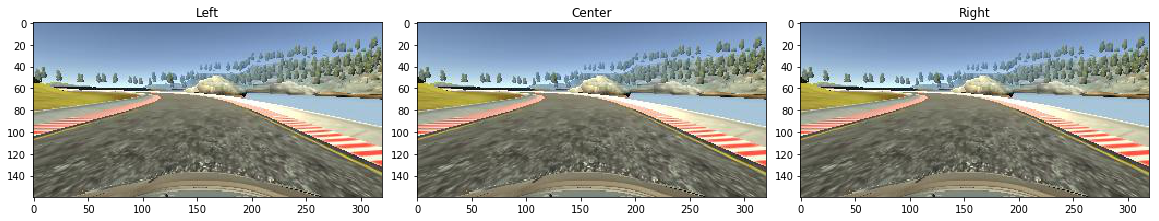

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
axs = axs.ravel()

for img, i in zip([("Left", 1), ("Center", 0), ("Right", 2)], range(0, 3)):
    source_path = train[0][0]
    
    axs[i].set_title(img[0])
    axs[i].imshow(read_image_rgb(source_path))

In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense,Lambda, Cropping2D, Dropout, Conv2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint

model = Sequential()
#model.add(Cropping2D(cropping=((60,20), (0,0)), input_shape=(160,320, 3)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(50,140, 3)))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(1164))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))


model.compile(loss='mse', optimizer='adam')

# Generators
import random


def generator(driving_log, batch_size, shape=(50, 140)):    
    correction_factor = [0, 0.2, -0.2]
    
    # Create empty arrays to contain batch of features and labels#
    batch_images = np.zeros((batch_size, shape[0], shape[1], 3))
    batch_measurements = np.zeros((batch_size, 1))
    
    while True:
        i = 0
        while i < batch_size:
            # choose random index in features
            log = random.choice(driving_log)            
            img_index = random.choice(range(0, 3))
            
            source_path = log[img_index]            
            
            image_rgb = read_image_rgb(source_path)
            cropped = image_rgb[60:-10,20:-20]
            image = cv2.resize(cropped, (140, 50), interpolation=cv2.INTER_AREA)

            measurement = float(log[3]) + correction_factor[img_index]

            batch_images[i] = image
            batch_measurements[i] = measurement

            batch_images[i+1] = np.fliplr(image)
            batch_measurements[i+1] = -measurement

            i += 2            
            
        yield batch_images, batch_measurements

batch_size=64
epochs=25

model.fit_generator(generator(train, batch_size),
                    validation_data=generator(valid, batch_size),
                    samples_per_epoch=6464,
                    nb_val_samples=len(valid), 
                    nb_epoch=epochs
                   )
model.save('model.h5')


Using TensorFlow backend.
/home/bibagimon/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/25
6464/6464 [==============================] - 12s - loss: 0.0261 - val_loss: 0.0228
Epoch 2/25
6464/6464 [==============================] - 8s - loss: 0.0164 - val_loss: 0.0190
Epoch 3/25
6464/6464 [==============================] - 7s - loss: 0.0171 - val_loss: 0.0213
Epoch 4/25
6464/6464 [==============================] - 6s - loss: 0.0166 - val_loss: 0.0171
Epoch 5/25
6464/6464 [==============================] - 6s - loss: 0.0161 - val_loss: 0.0143
Epoch 6/25
6464/6464 [==============================] - 6s - loss: 0.0170 - val_loss: 0.0191
Epoch 7/25
6464/6464 [==============================] - 6s - loss: 0.0158 - val_loss: 0.0168
Epoch 8/25
6464/6464 [==============================] - 6s - loss: 0.0157 - val_loss: 0.0165
Epoch 9/25
6464/6464 [==============================] - 6s - loss: 0.0160 - val_loss: 0.0151
Epoch 10/25
6464